In [399]:
#import required modules
import os
import numpy as np
import pandas as pd
from Bio import pairwise2
import matplotlib.pyplot as plt

In [54]:
#read in the numts csv files
parent_dir=os.path.join('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/')
dfs=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/')).apply(
lambda filename: pd.read_csv(parent_dir+filename) if filename.count('.')==1 else print(filename))
dfs.index=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/csvs/')).apply(
    lambda filename:filename[:-4])
dfs=dfs.drop(labels=['._Mus_musculus_fvbnj_numts','Mus_musculus_lpj_numts','Mus_musculus_c3hhej_numts','Mus_musculus_balbcj_numts',
                                           'Mus_musculus_aj_numts','Mus_musculus_nodshiltj_numts','Mus_musculus_akrj_numts',
                                           'Mus_musculus_dba2j_numts','Mus_musculus_129s1svimj_numts','Mus_musculus_cbaj_numts',
                                           'Mus_musculus_nzohlltj_numts','Mus_musculus_fvbnj_numts','Mus_musculus_c57bl6nj_numts'])
dfs

._Mus_musculus_fvbnj_numts.csv


Mus_musculus_casteij_numts          score      eg2_value        e_value g_id ...
Mus_musculus_wsbeij_numts           score      eg2_value        e_value g_id ...
Mus_musculus_pwkphj_numts           score      eg2_value        e_value g_id ...
Mus_musculus_numts                  score      eg2_value        e_value g_id ...
Mus_musculus_spreteij_numts         score      eg2_value        e_value g_id ...
dtype: object

In [58]:
#drop the columns that we dont need
def drop_columns(df):
    df=df.drop(labels=['score','eg2_value','e_value','g_strand','mt_strand','g_size'],axis=1)
    df=df[df['mt_start']<17000]
    return(df)

numt_dfs=dfs.apply(drop_columns)
numt_dfs.index=['casteij','wsbeij','pwkphj','mm','spretus']
numt_dfs

casteij        g_id    g_start  mt_start  g_length  mt_le...
wsbeij         g_id   g_start  mt_start  g_length  mt_len...
pwkphj         g_id    g_start  mt_start  g_length  mt_le...
mm             g_id   g_start  mt_start  g_length  mt_len...
spretus        g_id    g_start  mt_start  g_length  mt_le...
dtype: object

In [41]:
#get MITOS annotations
def get_mitos_dfs(filename):
    try:
        df=pd.read_csv(f'/Volumes/motilin/balint/numt/mice_strains_numt/mt_annotations/{filename}',sep='\t',
                       header=None)
        df.columns=['mt','start','end','gene_name','significance','strand']
        return(df)
    except:
        return(np.nan)
    
mitos_dfs=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/mt_annotations/')).apply(get_mitos_dfs)
mitos_dfs.index=pd.Series(os.listdir('/Volumes/motilin/balint/numt/mice_strains_numt/mt_annotations/')).apply(
    lambda filename: filename.split('.')[0])
mitos_dfs=mitos_dfs.dropna()
mitos_dfs=mitos_dfs.drop(labels=['cbaj','aj','nzohlltj','akrj','fvbnj','129s1svimj','c57bl6nj','lpj','nodshiltj',
                                'balbcj','dba2j','c3hhej'])
mitos_dfs

mm             mt  start    end   gene_name  significance...
pwkphj                mt  start    end   gene_name  signi...
casteij               mt  start    end   gene_name  signi...
wsbeij                mt  start    end   gene_name  signi...
spretus               mt  start    end   gene_name  signi...
dtype: object

In [129]:
#read the gene ids
def get_gene_ids(strain):
    if strain=='mm':
        filename='mm.csv'
    else:
        filename='mm%s.csv' % strain
    df=pd.read_csv('/Volumes/motilin/balint/numt/mice_strains_numt/gene_ids/%s' % filename,index_col=0)
    g_ids=[]
    starts=[]
    ends=[]
    df['ind'].apply(lambda item: g_ids.append(item.split(':')[0]))
    df['ind'].apply(lambda item: starts.append(int(item.split(':')[1])))
    df['ind'].apply(lambda item: ends.append(int(item.split(':')[-1].split('.')[0])))
    df=df.drop(labels=['ind'],axis=1)
    df['g_id']=g_ids
    df['start']=starts
    df['end']=ends
    return(df)

gene_dfs=pd.Series(mitos_dfs.index.values).apply(get_gene_ids)
gene_dfs.index=mitos_dfs.index.values
gene_dfs

mm               values g_id      start        end
1    G...
pwkphj                values g_id      start        end
1...
casteij         values g_id      start        end
1    mt...
wsbeij          values g_id      start        end
1     m...
spretus          values g_id      start        end
1     ...
dtype: object

In [205]:
#function for linking mitos, genes and numt dfs
def link_dfs(row, strain):
    global mitochondrial_genes
    global nuclear_genes
    mitos_df=mitos_dfs[strain]
    mitos_df=mitos_df[mitos_df['start']>row['mt_start']]
    mitos_df=mitos_df[mitos_df['end']<(row['mt_start']+row['mt_length'])]
    mitochondrial_gene=list(mitos_df['gene_name'])
    
    gene_df=gene_dfs[strain]
    gene_df=gene_df[gene_df['g_id']==row['g_id']]
    nuclear_gene=gene_df[gene_df['start']==row['g_start']]['values'].tolist()
    if len(nuclear_gene)==1:
        mitochondrial_genes.append(mitochondrial_gene)
        nuclear_genes.append(nuclear_gene[0])
    else:
        mitochondrial_genes.append(np.nan)
        nuclear_genes.append(np.nan)

In [210]:
#link mm dfs 
mitochondrial_genes=[]
nuclear_genes=[]
numt_dfs['mm'].apply(link_dfs,args=('mm',),axis=1)
numt_dfs['mm']['mt_genes']=mitochondrial_genes
numt_dfs['mm']['g_genes']=nuclear_genes
numt_dfs['mm']=numt_dfs['mm'].dropna(subset=['g_genes'])
numt_dfs['mm']

,g_id,g_start,mt_start,g_length,mt_length,g_sequence,mt_sequence,mt_genes,g_genes
2,5,84766087,4846,1588,1594,AAAATAATTACCCACCACACATGCTTCAAAAATAACTTTATCCTTc...,AAAataataactcaCCAAACAAAAACTAAACCCAACCTAATATTTT...,"[trnW(tga), trnA(gca), trnN(aac), trnC(tgc), t...",Gm43531
11,9,15230422,1954,887,968,AGAAATATAACCATTAGAGGCATTGCCTACCCAGTGACTAATGTTA...,AGCATTACAAGTATTAGAGGCACTGCCTGCCCAGTGACTAAAGTTT...,[trnL2(tta)],Cep295
12,6,79794898,1737,432,429,TATGAGTAACAAGAATCTTAATTCTCCAAACATACATGTATAACAA...,TATGAGTAACAAGAATTCCAATTCTCCAGGCATACGCGTATAACAA...,[],Gm20594
13,5,112904397,6008,644,657,CCTATCCTTTATTAACACTTATTCTGATTCTCCAGTCACCCAGAAG...,CCAATTCTCTACCAGCATCTGTTCTGATTCTTTGGGCACCCAGAAG...,[],Myo18b
14,12,59309459,3393,429,429,acacaGCCGGCCCATTCGCATTATTTTTTATAGCAGAGTATACTAA...,ACGCAGCCGGCCCATTCGCGTTATTCTTTATAGCAGAGTACACTAA...,[trnI(atc)],Gm48258
16,18,65252674,15423,396,398,GTACATAAAATTACATAGTACAATAGAACATTAATGTATatcgtac...,GTACATAAATttacatagtacaacagtacatttatgtatatcgtac...,[],Nedd4l
20,8,31888075,14920,396,399,TAACCCACTGAACACACTACCCCATGTTAAACCAGAATGATACTTC...,TAATCCACTAAACACCCCACCCCATATTAAACCCGAATGATATTTC...,[],Gm53049
22,9,15231607,2909,419,424,aaactttTCATAAAAGAACTGATACTCCCCCTAACGACCTCAGTAT...,AAATTATTTATAAAAGAACCAATACGCCCTTTAACAACCTCTATAT...,[],Cep295
24,1,142657264,10307,484,487,aaatatataaatttctcaattATGTTTTCCTCAGACCC--TTTTCA...,AATTATAAAAACTTTTCAAATATATTCTCCTCAGACCCCCTATCCA...,[],Gm28724
26,1,142650581,9865,487,464,TAATTATAAATATAACATCTGCCTTCCTTATCCTTTCACTAGCTTT...,TAATTACCAATATGCCATCTACCTTCTTCAACCTCACCATAGCCTT...,[nad4l],Gm28724


In [209]:
#link casteij dfs 
mitochondrial_genes=[]
nuclear_genes=[]
numt_dfs['casteij'].apply(link_dfs,args=('casteij',),axis=1)
numt_dfs['casteij']['mt_genes']=mitochondrial_genes
numt_dfs['casteij']['g_genes']=nuclear_genes
numt_dfs['casteij']=numt_dfs['casteij'].dropna(subset=['g_genes'])
numt_dfs['casteij']

,g_id,g_start,mt_start,g_length,mt_length,g_sequence,mt_sequence,mt_genes,g_genes
0,4,77310168,12781,1942,1938,TTCATAGCCTGGCAGATGAACAAGACATCCAAAAAATAGGAAACAT...,TTCATAGCCTGGCAGACGAACAAGACATCCGAAAAATAGGAAACAT...,"[nad6, trnE(gaa)]",mt-Nd6
3,5,4292753,14715,1002,998,GCCATAGTAATTTTTCATCTCCTTTTTCCTTCACAAAACAGGATCA...,GCCCTAGCAATCGTTCACCTTCTTTT-CCTTCACGAAACAGGATCA...,"[trnT(aca), trnP(cca)]",Zfp804b
5,2,19982447,4721,414,414,ttataaaaaataactgtctaatcatagcaacactcatagcaataat...,TTATAAAAAATAACTGTCTAATCATAGCAACACTcatagcaaTAAT...,"[trnW(tga), trnA(gca)]",Myo3a
7,9,12418569,4721,414,414,TTATAAAAAATAACTGTCTAATCATAGCAACACTcatagcaaTAAT...,TTATAAAAAATAACTGTCTAATCATAGCAACACTcatagcaaTAAT...,"[trnW(tga), trnA(gca)]",Cep295
8,9,12416854,1954,887,968,AGAAATATAACCATTAGAGGCATTGCCTACCCAGTGACTAATGTTA...,AGCATTACAAGTATTAGAGGCACTGCCTGCCCAGTGACTAAAGTTT...,[trnL2(tta)],Cep295
9,9,12419206,4522,758,798,AACTTAATTATTTATATTATCCTTACAGTTCCAATATTTATTCCAC...,AACCTCATAATCTACATTATTCTCACAGTCCCTATATTCATAGCAC...,"[trnW(tga), trnA(gca), trnN(aac), trnC(tgc)]",Cep295
11,12,53130610,3393,429,429,acacaGCCGGCCCATTCGCATTATTTTTTATAGCAGAGTATACTAA...,ACGCAGCCGGCCCATTCGCGTTATTCTTTATAGCAGAGTACACTAA...,[trnI(atc)],mt-Ti
12,2,19982101,4457,335,335,CATCAATTGCCCACATAGGATGAATATTAGCAATCCTTCCTTACAA...,CATCAATTGCCCACATAGGATGAATATTAGCAATCCTTCCTTACAA...,[],Myo3a
13,5,113747381,6045,609,621,CATCCAGAAGTTTATATTCTTATTCTCCCAGGATTTGCAATC-TTT...,CACCCAGAAGTTTATATTCTCATCCTCCCAGGATTTGGAATTATTT...,[],Myo18b
15,6,79763672,1737,434,429,TATGAGTAACAAGAATCTTAATTCTCCAAACATACATGTATAACAA...,TATGAGTAACAAGAATTCCAATTCTCCAGGCATACGCGTATAACAA...,[],Gm20594


In [211]:
#link pwkphj dfs 
mitochondrial_genes=[]
nuclear_genes=[]
numt_dfs['pwkphj'].apply(link_dfs,args=('pwkphj',),axis=1)
numt_dfs['pwkphj']['mt_genes']=mitochondrial_genes
numt_dfs['pwkphj']['g_genes']=nuclear_genes
numt_dfs['pwkphj']=numt_dfs['pwkphj'].dropna(subset=['g_genes'])
numt_dfs['pwkphj']

,g_id,g_start,mt_start,g_length,mt_length,g_sequence,mt_sequence,mt_genes,g_genes
1,5,4079496,14718,1002,997,GCCATAGTAATTTTTCATCTCCTTTTTCCTTCACAAAACAGGATCA...,GCCCTAGCAATCGTTCACCTTCTTTT-CCTCCACGAAACAGGATCA...,"[trnT(aca), trnP(cca)]",Zfp804b
4,9,12177223,4519,762,802,ACTTAACTTAATTATTTATATTATCCTTACAGTTCCAATATTTATT...,ACTCAACCTCATAATCTATATTATTCTCACAGTCCCTATATTCATA...,"[trnW(tga), trnA(gca), trnN(aac), trnC(tgc)]",Cep295
5,9,12174956,1954,882,969,AGAAATATAACCATTAGAGGCATTGCCTACCCAGTGACTAATGTTA...,AGCATTACAAGTATTAGAGGCACTGCCTGCCCAGTGACTAAAGTTT...,[trnL2(tta)],Cep295
6,12,50604480,3394,429,429,acacaGCCGGCCCATTCGCATTATTTTTTATAGCAGAGTATACTAA...,ACGCAGCCGGCCCATTCGCGTTATTCTTTATAGCAGAGTACACTAA...,[trnI(atc)],mt-Ti
8,18,62320079,15427,393,395,GTACATAAAATTACATAGTACAATAGAACATTAATGTATattgtac...,GTACATAAATTTACATAGTACAATAgtacatttatgtatatcgtac...,[],Nedd4l
9,9,12177977,5352,476,483,CTCAACCAACTCTAAAGATATTGGAACTCTCTATGTCCTATTCAAT...,CTCAACCAATCACAAAGATATCGGAACCCTATATCTACTATTTGGA...,[],Cep295
10,5,109554572,6122,504,521,AAGAGCCATTCAGATAGGTGGGCATAGTCTGAGCTATAATGTCCAT...,AAGAACCTTTCGGCTATATAGGAATAGTATGAGCAATAATGTCTAT...,[],Myo18b
11,6,75825670,1885,281,281,aaaaaaataaataaataaaaggaactcggaaaACAAAAACCCCGCC...,AAAGATCTAAAAAGATAAAAGGAACTCGGCAAACAAGAACCCCGCC...,[],Gm20594
12,16,81754400,10131,454,446,GTATGGAACAGACTATGTACAAAACCCTAACCTTCTACAATGCTAA...,GTACGGAACAGATTACGTCCAAAATCTTAACCTACTACAATGCTAA...,[],App
17,6,110760213,8432,545,542,TTCTCAAAACACCTAATTGGCAGTACTACATTAGTTTTATTAA-TA...,TTATTAATACACCTAATCGGAGGAGCTACACTAGTACTAATAAATA...,[],Atg7


In [212]:
#link spretus dfs 
mitochondrial_genes=[]
nuclear_genes=[]
numt_dfs['spretus'].apply(link_dfs,args=('spretus',),axis=1)
numt_dfs['spretus']['mt_genes']=mitochondrial_genes
numt_dfs['spretus']['g_genes']=nuclear_genes
numt_dfs['spretus']=numt_dfs['spretus'].dropna(subset=['g_genes'])
numt_dfs['spretus']

,g_id,g_start,mt_start,g_length,mt_length,g_sequence,mt_sequence,mt_genes,g_genes
2,10,88519229,3811,804,802,TTCGTGCTACCTAAACACCTCATCCTATAGTAAGGTCAGCTAATTA...,TTCGTGCTACCTAAACACCTCATCCTATAGTAAGGTCAGCTAATTA...,[trnM(atg)],Ano4
8,9,12394362,1965,873,951,ATTAGAGGCATTGCCTACCCAGTGACTAATGTTAAACTGCTGCAGT...,ATTAGAGGCACTGCCTGCCCAGTGACTAAAGTTTAACGGCCGCGGT...,[trnL2(tta)],Cep295
9,9,12395921,4401,865,918,GAACATGAGGTGGACTTAAGCAAACACAAATGTGAAAAATTATAGC...,GAGCATGAGGAGGACTTAATCAAACACAAATACGAAAAATTATAGC...,"[trnW(tga), trnA(gca), trnN(aac), trnC(tgc)]",Cep295
10,1,32750627,11394,715,711,TAATTGCTACAACCCAATGAGGGAAGCTAATTAATCATATAAATAA...,TAATTATCACCACCCAACGTGGCAAACTAACCAACCATATAATTAA...,"[trnH(cac), trnS1(agc), trnL1(cta)]",Arhgef4
12,6,78491238,1736,431,429,TATGAGTAACAAGAATCTAAATTCTCCAAACATACGTGTATAACAA...,TATGAGTAACAAGAATTCTAATTCTCCAGGCATACGCATATAACAA...,[],Gm20594
14,5,111313621,6044,584,597,CATCCAGAAGTTTATATTCTTATTCTCCCAGGATTTGGAATC-TTT...,CACCCAGAAGTTTATATTCTTATTCTTCCAGGATTCGGAATTATTT...,[],Myo18b
15,18,64530496,15424,396,395,GTACATAAAATTACATAGTACAATAGAacattaatgtacatcatac...,GTACATAAATTtacatagtacaatagtacatttatgtatatcgtac...,[],Nedd4l
17,9,12396778,5350,478,488,CTCAACCAACTCTAAAGATATTGGAACTCTCTATGTCCTATTCAAT...,CTCAACCAATCATAAAGATATCGGAACCCTGTATTTACTATTCGGA...,[],Cep295
21,16,84091681,10127,456,448,GTATGGAACAGACTATGTACAAAACCTTAACCTTCTACAATGCTAA...,GTACGGAACAGACTACGTCCAAAACCTCAACCTCCTACAATGCTAA...,[],App
22,1,182266809,702,306,306,TAAGACGGTATAGAAGTAAGCAAAAGAA-CAAACATAAGAACATTA...,TAAAAAGGTATTAAAGTAAGCAAAAGAATCAAACATAAAAACGTTA...,[],Smyd3


In [213]:
#link wsbeij dfs 
mitochondrial_genes=[]
nuclear_genes=[]
numt_dfs['wsbeij'].apply(link_dfs,args=('wsbeij',),axis=1)
numt_dfs['wsbeij']['mt_genes']=mitochondrial_genes
numt_dfs['wsbeij']['g_genes']=nuclear_genes
numt_dfs['wsbeij']=numt_dfs['wsbeij'].dropna(subset=['g_genes'])
numt_dfs['wsbeij']

,g_id,g_start,mt_start,g_length,mt_length,g_sequence,mt_sequence,mt_genes,g_genes
0,4,78951738,13911,1447,1447,ATTAAACCTAAAAACGATCCACCAAACCCtaaaaccattaaacaac...,ATTAAACCTAAAAACGATCCACCAAACCCtaaaaccattaaacaac...,"[trnE(gaa), cob, trnT(aca)]",mt-Tt
1,4,78950542,13061,1195,1193,taatctccattaacgaaaatgacccagacctcataaacccaatcaa...,TAATCTCCATTAACGAAAATGACCCAGACCTCATAAACCCAATCAA...,"[nad6, trnE(gaa)]",mt-Nd6
5,5,4257513,14716,792,789,GCCATAGTAATTTTTCATCTCCTTTTTCCTTCACAAAACAGGATCA...,GCCCTAGCAATCGTTCACCTCCTCTT-CCTCCACGAAACAGGATCA...,"[trnT(aca), trnP(cca)]",Zfp804b
8,9,12130742,4396,879,923,ATTCTCATAGGAACATGAGGTGGACTTAAGCATACACAAATGTGAA...,ATTTTCATAGGGGCATGAGGAGGACTTAACCAAACACAAATACGAA...,"[trnW(tga), trnA(gca), trnN(aac), trnC(tgc)]",Cep295
9,9,12129133,1954,887,968,AGAAATATAACCATTAGAGGCATTGCCTACCCAGTGACTAATGTTA...,AGCATTACAAGTATTAGAGGCACTGCCTGCCCAGTGACTAAAGTTT...,[trnL2(tta)],Cep295
...,...,...,...,...,...,...,...,...,...
158,4,41901316,5353,88,88,GGATAGGCTATATATTTTGTTAATGGATCTAAAATAATGGAAATTC...,GGGTATGCTATATATTTTGTTAGTGGGTCTAGAATAATGGAGATGC...,[],Rnf38
160,12,118947664,9513,93,93,TAAGAAACTGATAGGACTTCTCGTTTGGAGGCAAAAGCTTCTCAGA...,TACGATACTGATATTACTTCTCGTTTTGAAGCAAAGGCCTCTCAAA...,[],Ptprn2
163,1,128459690,9375,72,73,AGGTTATAAGATTGGCTTGAAGCCAGTTTTAGGGTGTTCGATTCCA...,AGGATATGAGATTGGCTTGAAACCAATTTTAGGGGGTTCGATTCCT...,[],Nckap5
167,7,34556981,15585,65,65,AACATCATTTTAGGGTTTGCTGAAGATGGCCATGTATTGACTAAAC...,AATACCTTTTTAGGGTTTGCTGAAGATGGCGGTATATAGGCTGAAT...,[],Lrp3


In [281]:
#function for doing pairwise alignments
def pairwise_alignment(row,strain,sequence_type):
    global pairwise_alignments
    wild_strain=numt_dfs[strain].loc[numt_dfs[strain]['g_genes']==row['g_genes']]
    mm_sequence=row[sequence_type].replace('-','').upper()
    if len(wild_strain)!=0:
        strain_sequence=wild_strain[sequence_type].tolist()[0].replace('-','').upper()
        alignments = pairwise2.align.localms(mm_sequence, strain_sequence,
                                             2,-1,-1.5,-0.1,
                                             one_alignment_only = True)
        pairwise_alignments.append([alignments[0][0],alignments[0][1]])

In [284]:
#mm csateij alignments
pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('casteij','g_sequence',),axis=1)
casteij_g_alignments=pd.DataFrame(pairwise_alignments)
casteij_g_alignments.columns=['mm','casteij']

pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('casteij','mt_sequence',),axis=1)
casteij_mt_alignments=pd.DataFrame(pairwise_alignments)
casteij_mt_alignments.columns=['mm','casteij']

In [286]:
#mm pwkphj alignments
pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('pwkphj','g_sequence',),axis=1)
pwkphj_g_alignments=pd.DataFrame(pairwise_alignments)
pwkphj_g_alignments.columns=['mm','pwkphj']

pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('pwkphj','mt_sequence',),axis=1)
pwkphj_mt_alignments=pd.DataFrame(pairwise_alignments)
pwkphj_mt_alignments.columns=['mm','pwkphj']

In [287]:
#mm spretus alignments
pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('spretus','g_sequence',),axis=1)
spretus_g_alignments=pd.DataFrame(pairwise_alignments)
spretus_g_alignments.columns=['mm','spretus']

pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('spretus','mt_sequence',),axis=1)
spretus_mt_alignments=pd.DataFrame(pairwise_alignments)
spretus_mt_alignments.columns=['mm','spretus']

In [288]:
#mm wsbeij alignments
pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('wsbeij','g_sequence',),axis=1)
wsbeij_g_alignments=pd.DataFrame(pairwise_alignments)
wsbeij_g_alignments.columns=['mm','wsbeij']

pairwise_alignments=[]
numt_dfs['mm'].apply(pairwise_alignment,args=('wsbeij','mt_sequence',),axis=1)
wsbeij_mt_alignments=pd.DataFrame(pairwise_alignments)
wsbeij_mt_alignments.columns=['mm','wsbeij']

In [321]:
import math
math.sqrt(9)

3.0

In [365]:
def kimura2(row,strain):
    purins=['A','G']
    pyrimidines=['C','T']
    seq1=row['mm']
    seq2=row[strain]
    transitions=0
    transversions=0
    for index, nucleotide_a in enumerate(seq1):
        nucleotide_b=seq2[index]
        if nucleotide_a!='-' and (nucleotide_a!=nucleotide_b):
            if ((nucleotide_a in purins and nucleotide_b in purins) or
                (nucleotide_a in pyrimidines and nucleotide_b in pyrimidines)):
                transitions+=1
            else:
                transversions+=1
    transitions=transitions/len(seq1.replace('-',''))
    transversions=transversions/len(seq1.replace('-',''))
    if [transitions,transversions]==[0,0]:
        return [np.nan,np.nan]
    else:
        
        return [transitions,transversions]

In [386]:
casteij_g_kimura=pd.DataFrame(casteij_g_alignments.apply(kimura2,args=('casteij',),axis=1).tolist())
casteij_g_kimura.columns=['transitions','transversions']
casteij_g_kimura=casteij_g_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [385]:
casteij_mt_kimura=pd.DataFrame(casteij_mt_alignments.apply(kimura2,args=('casteij',),axis=1).tolist())
casteij_mt_kimura.columns=['transitions','transversions']
casteij_mt_kimura=casteij_mt_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [384]:
pwkphj_g_kimura=pd.DataFrame(pwkphj_g_alignments.apply(kimura2,args=('pwkphj',),axis=1).tolist())
pwkphj_g_kimura.columns=['transitions','transversions']
pwkphj_g_kimura=pwkphj_g_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [383]:
pwkphj_mt_kimura=pd.DataFrame(pwkphj_mt_alignments.apply(kimura2,args=('pwkphj',),axis=1).tolist())
pwkphj_mt_kimura.columns=['transitions','transversions']
pwkphj_mt_kimura=pwkphj_mt_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [382]:
spretus_g_kimura=pd.DataFrame(spretus_g_alignments.apply(kimura2,args=('spretus',),axis=1).tolist())
spretus_g_kimura.columns=['transitions','transversions']
spretus_g_kimura=spretus_g_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [381]:
spretus_mt_kimura=pd.DataFrame(spretus_mt_alignments.apply(kimura2,args=('spretus',),axis=1).tolist())
spretus_mt_kimura.columns=['transitions','transversions']
spretus_mt_kimura=spretus_mt_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [380]:
wsbeij_g_kimura=pd.DataFrame(wsbeij_g_alignments.apply(kimura2,args=('wsbeij',),axis=1).tolist())
wsbeij_g_kimura.columns=['transitions','transversions']
wsbeij_g_kimura=wsbeij_g_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [379]:
wsbeij_mt_kimura=pd.DataFrame(wsbeij_mt_alignments.apply(kimura2,args=('wsbeij',),axis=1).tolist())
wsbeij_mt_kimura.columns=['transitions','transversions']
wsbeij_mt_kimura=wsbeij_mt_kimura.apply(
    lambda row:-(1/2)*np.log((1-2*row['transitions']-row['transversions'])*np.sqrt((1-2*row['transversions']))),
    axis=1)

In [397]:
def visual_dataprep(kimura_g,kimura_mt):
    g_kimura=[]
    mt_kimura=[]
    for index,g_element in enumerate(kimura_g.tolist()):
        mt_element=kimura_mt.tolist()[index]
        if np.isnan(g_element)==False and np.isnan(mt_element)==False:
            g_kimura.append(g_element)
            mt_kimura.append(mt_element)
    return [g_kimura,mt_kimura]

In [401]:
casteij_kimuras=visual_dataprep(casteij_g_kimura,casteij_mt_kimura)
pwkphj_kimuras=visual_dataprep(pwkphj_g_kimura,pwkphj_mt_kimura)
spretus_kimuras=visual_dataprep(spretus_g_kimura,spretus_mt_kimura)
wsbeij_kimuras=visual_dataprep(wsbeij_g_kimura,wsbeij_mt_kimura)

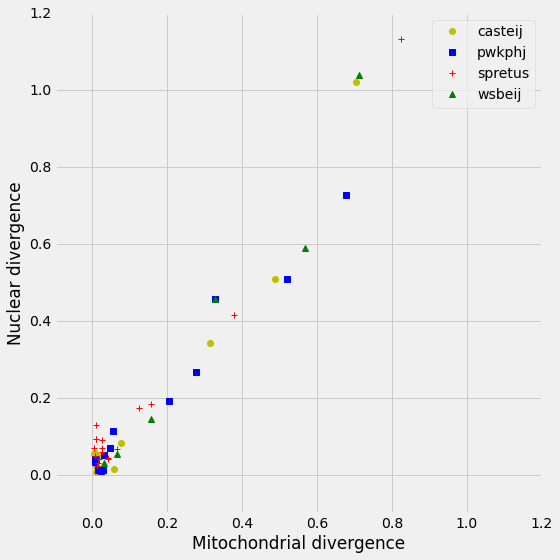

In [440]:
plt.style.use('fivethirtyeight')
fig,axs=plt.subplots(1,1,figsize=(8,8))
axs.plot(casteij_kimuras[0],casteij_kimuras[1],'yo',label='casteij')
axs.plot(pwkphj_kimuras[0],pwkphj_kimuras[1],'bs',label='pwkphj')
axs.plot(spretus_kimuras[0],spretus_kimuras[1],'r+',label='spretus')
axs.plot(wsbeij_kimuras[0],wsbeij_kimuras[1],'g^',label='wsbeij')
axs.set_xlim(-0.1,1.2)
axs.set_ylim(-0.1,1.2)
axs.set_ylabel('Nuclear divergence')
axs.set_xlabel('Mitochondrial divergence')
plt.legend()
plt.tight_layout()
plt.savefig('../results/kimura2_parameter.png',dpi=85)